# Setup


In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
working_directory = 'GitHub/dl-superresolution-ipynb'
%cd /content/drive/MyDrive/$working_directory


/content/drive/MyDrive/GitHub/dl-superresolution-ipynb


In [4]:
%ls

dl-superresolution.ipynb  input-pstride-64.zip  README.md         zipped_input.zip
input-pstride-32.zip      outputs/              requirements.txt


In [5]:
# Load Dataset by copying zipped file
zipped_input = "/content/drive/MyDrive/input-pstride-32.zip"
!cp $zipped_input .
!unzip $zipped_input

Streaming output truncated to the last 5000 lines.
  inflating: input/t91_hr_patches/tt5_53.png  
  inflating: input/t91_hr_patches/tt5_54.png  
  inflating: input/t91_hr_patches/tt5_55.png  
  inflating: input/t91_hr_patches/tt5_56.png  
  inflating: input/t91_hr_patches/tt5_57.png  
  inflating: input/t91_hr_patches/tt5_58.png  
  inflating: input/t91_hr_patches/tt5_59.png  
  inflating: input/t91_hr_patches/tt5_6.png  
  inflating: input/t91_hr_patches/tt5_60.png  
  inflating: input/t91_hr_patches/tt5_61.png  
  inflating: input/t91_hr_patches/tt5_62.png  
  inflating: input/t91_hr_patches/tt5_63.png  
  inflating: input/t91_hr_patches/tt5_64.png  
  inflating: input/t91_hr_patches/tt5_65.png  
  inflating: input/t91_hr_patches/tt5_66.png  
  inflating: input/t91_hr_patches/tt5_67.png  
  inflating: input/t91_hr_patches/tt5_68.png  
  inflating: input/t91_hr_patches/tt5_69.png  
  inflating: input/t91_hr_patches/tt5_7.png  
  inflating: input/t91_hr_patches/tt5_70.png  
  inflating

In [ ]:
%pip install -r requirements.txt

In [ ]:
!git checkout vanishing-grad

In [ ]:
# cleans cruft out of the git repo. Allows for faster !git status
!git gc

In [ ]:
# Check Which GPU You've Been Assigned
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

## Git Management


In [ ]:
#!git config --global user.email "e11909390@student.tuwien.ac.at"
#!git config --global user.name "Lollobin"

In [ ]:
#!git pull

In [1]:
!git status

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
#!git commit -a -m "added connection for google colab"

In [ ]:
#!git push

# Preparation


## Data Preprocessing

Generate patches for training and low res images for validation and testing.


### Patch Generation


In [ ]:
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import patchify
import numpy as np
import matplotlib.gridspec as gridspec
import glob as glob
import os
import cv2

SHOW_PATCHES = False
STRIDE = 32
SIZE = 32

def show_patches(patches):
    plt.figure(figsize=(patches.shape[0], patches.shape[1]))
    gs = gridspec.GridSpec(patches.shape[0], patches.shape[1])
    gs.update(wspace=0.01, hspace=0.02)
    counter = 0
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            ax = plt.subplot(gs[counter])
            plt.imshow(patches[i, j, 0, :, :, :])
            plt.axis('off')
            counter += 1
    plt.show()

def create_patches(
    input_paths, out_hr_path, out_lr_path,
):
    os.makedirs(out_hr_path, exist_ok=True)
    os.makedirs(out_lr_path, exist_ok=True)
    all_paths = []
    for input_path in input_paths:
        all_paths.extend(glob.glob(f"{input_path}/*"))
    print(f"Creating patches for {len(all_paths)} images")
    for image_path in tqdm(all_paths, total=len(all_paths)):
        image = Image.open(image_path)
        image_name = image_path.split(os.path.sep)[-1].split('.')[0]
        w, h = image.size
        # Create patches of size (32, 32, 3)
        patches = patchify.patchify(np.array(image), (32, 32, 3), STRIDE)
        if SHOW_PATCHES:
            show_patches(patches)
        counter = 0
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                counter += 1
                patch = patches[i, j, 0, :, :, :]
                patch = cv2.cvtColor(patch, cv2.COLOR_RGB2BGR)
                cv2.imwrite(
                    f"{out_hr_path}/{image_name}_{counter}.png",
                    patch
                )
                # Convert to bicubic and save.
                h, w, _ = patch.shape
                low_res_img = cv2.resize(patch, (int(w*0.5), int(h*0.5)),
                                        interpolation=cv2.INTER_CUBIC)
                # Now upscale using BICUBIC.
                high_res_upscale = cv2.resize(low_res_img, (w, h),
                                            interpolation=cv2.INTER_CUBIC)
                cv2.imwrite(
                    f"{out_lr_path}/{image_name}_{counter}.png",
                    high_res_upscale
                )

In [ ]:
create_patches(['input/T91'], 'input/stride32/t91_hr_patches', 'input/stride32/t91_lr_patches')

### Bicubic Scaling for Validation


In [ ]:
from PIL import Image
import glob as glob
import os

paths = ['input/Set14/original', 'input/Set5/original']
scale_factor = '2x' # options 2x, 3x, 4x
images = []

for path in paths:
    images.extend(glob.glob(f"{path}/*.png"))
print(len(images))
# Select scaling-factor and set up directories according to that.
if scale_factor == '2x':
    scale_factor = 0.5
    os.makedirs('input/test_bicubic_rgb_2x', exist_ok=True)
    save_path_lr = 'input/test_bicubic_rgb_2x'
    os.makedirs('input/test_hr', exist_ok=True)
    save_path_hr = 'input/test_hr'
if scale_factor == '3x':
    scale_factor = 0.333
    os.makedirs('input/test_bicubic_rgb_3x', exist_ok=True)
    os.makedirs('input/test_hr', exist_ok=True)
    save_path_lr = 'input/test_bicubic_rgb_3x'
    save_path_hr = 'input/test_hr'
if scale_factor == '4x':
    scale_factor = 0.25
    os.makedirs('input/test_bicubic_rgb_4x', exist_ok=True)
    os.makedirs('input/test_hr', exist_ok=True)
    save_path_lr = 'input/test_bicubic_rgb_4x'
    save_path_hr = 'input/test_hr'
print(f"Scaling factor: {scale_factor}")
print(f"Low resolution images save path: {save_path_lr}")
for image in images:
    orig_img = Image.open(image)
    image_name = image.split(os.path.sep)[-1]
    w, h = orig_img.size[:]
    print(f"Original image dimensions: {w}, {h}")
    orig_img.save(f"{save_path_hr}/{image_name}")
    low_res_img = orig_img.resize((int(w*scale_factor), int(h*scale_factor)), Image.BICUBIC)
    # Upscale using BICUBIC.
    high_res_upscale = low_res_img.resize((w, h), Image.BICUBIC)
    high_res_upscale.save(f"{save_path_lr}/{image_name}")

## Utils

Define utility functions that are used later on.


In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.utils import save_image
plt.style.use('ggplot')
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    Note that the output and label pixels (when dealing with images) should
    be normalized as the `max_val` here is 1 and not 255.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    diff = outputs - label
    rmse = math.sqrt(np.mean((diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

def save_plot(train_loss, val_loss, train_psnr, val_psnr):

    # Loss plots.
    print('Saving loss plots...')
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(val_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/loss.png')
    plt.close()

    # PSNR plots.
    print('Saving PSNR plots...')
    plt.figure(figsize=(10, 7))
    plt.plot(train_psnr, color='green', label='train PSNR dB')
    plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.savefig('outputs/psnr.png')
    plt.close()

def save_model_state(model):
    # save the model to disk
    print('Saving model state...')
    torch.save(model.state_dict(), 'outputs/model.pth')

def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    # Remove the last model checkpoint if present.
    torch.save({
                'epoch': epochs+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"outputs/model_ckpt.pth")

def save_validation_results(outputs, epoch, batch_iter):
    """
    Function to save the validation reconstructed images.
    """
    save_image(
        outputs,
        f"outputs/valid_results/val_sr_{epoch}_{batch_iter}.png"
    )

# Data Loading


In [27]:
import numpy as np
import glob as glob
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms

TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 1


transform_image = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

transform_label = transforms.Compose([
        transforms.ToTensor(),
    ])

class ResNetSRCNNDataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.all_image_paths = glob.glob(f"{image_paths}/*")
        self.all_label_paths = glob.glob(f"{label_paths}/*")

    def __len__(self):
        return (len(self.all_image_paths))

    def __getitem__(self, index):
        image = Image.open(self.all_image_paths[index]).convert('RGB')
        label = Image.open(self.all_label_paths[index]).convert('RGB')

        image = transform_image(image)
        label = transform_label(label)

        return image, label

# Prepare the datasets.
def get_datasets(
    train_image_paths, train_label_paths,
    valid_image_path, valid_label_paths
):
    dataset_train = ResNetSRCNNDataset(
        train_image_paths, train_label_paths
    )
    dataset_valid = ResNetSRCNNDataset(
        valid_image_path, valid_label_paths
    )
    return dataset_train, dataset_valid

# Prepare the data loaders
def get_dataloaders(dataset_train, dataset_valid):
    train_loader = DataLoader(
        dataset_train,
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True
    )
    valid_loader = DataLoader(
        dataset_valid,
        batch_size=TEST_BATCH_SIZE,
        shuffle=False
    )
    return train_loader, valid_loader



In [28]:
%matplotlib inline

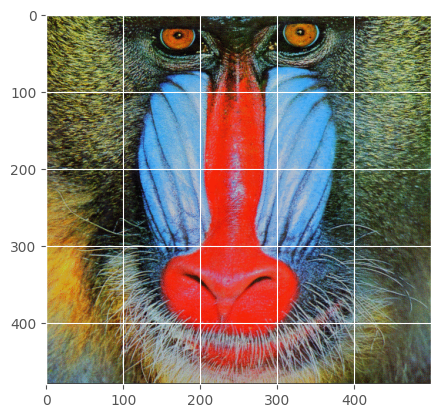

In [29]:

def imshow(img):
    img = img.numpy().transpose((1,2,0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)

TRAIN_LABEL_PATHS = 'input/t91_hr_patches'
TRAN_IMAGE_PATHS = 'input/t91_lr_patches'
VALID_LABEL_PATHS = 'input/test_hr'
VALID_IMAGE_PATHS = 'input/test_bicubic_rgb_2x'

dataset_train, dataset_valid = get_datasets(
    TRAN_IMAGE_PATHS, TRAIN_LABEL_PATHS,
    VALID_IMAGE_PATHS, VALID_LABEL_PATHS
)
train_loader, valid_loader = get_dataloaders(dataset_train, dataset_valid)

#images = next(iter(train_loader))
images = next(iter(valid_loader))

imshow(images[1][0])

# Network Definition


In [30]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Load a pretrained ResNet model
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

class ResNetSRCNN(nn.Module):
    def __init__(self):
        super(ResNetSRCNN, self).__init__()

        # Use only the initial layers of ResNet without downsampling
        self.resnet_layers = nn.Sequential(
            resnet.conv1,  # First convolutional layer
            resnet.bn1,    # Batch normalization
            resnet.relu,   # Activation
            resnet.layer1  # First residual block (without downsampling)
        )

        # Freeze the ResNet layers
        for param in self.resnet_layers.parameters():
            param.requires_grad = False

        # SRCNN-inspired layers for feature extraction and reconstruction
        self.reconstruction = nn.Sequential(
            nn.ConvTranspose2d(64,64,kernel_size=4,stride=2,padding=1), # Upscaling to keep input and output size the same
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Keep the spatial size same
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),   # Output RGB channels
        )

    def forward(self, x):
        # Pad the input
        original_size = x.size()[2:]
        scale_factor=2
        pad_h = (scale_factor - original_size[0] % scale_factor) % scale_factor
        pad_w = (scale_factor - original_size[1] % scale_factor) % scale_factor
        padding = (0, pad_w, 0, pad_h)  # (left, right, top, bottom)
        x = nn.functional.pad(x, padding, mode='reflect')

        # Feature extraction
        features = self.resnet_layers(x)

        # Reconstruction
        x = self.reconstruction(features)

        # Remove padding
        x = x[:, :, :original_size[0], :original_size[1]]

        return x

In [74]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Load a pretrained ResNet model
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

class model1(nn.Module):
    def __init__(self):
        super(model1, self).__init__()

        # Use only the initial layers of ResNet without downsampling
        self.resnet_layers = nn.Sequential(
            resnet.conv1,  # First convolutional layer
            resnet.bn1,    # Batch normalization
            resnet.relu,   # Activation
            #resnet.maxpool,  # Max pooling
            resnet.layer1,  # First residual block (without downsampling)
        )

        # Freeze the ResNet layers
        for param in self.resnet_layers.parameters():
            param.requires_grad = False

        # # SRCNN-inspired layers for feature extraction and reconstruction
        # self.reconstruction = nn.Sequential(
        #     nn.ConvTranspose2d(64,32,kernel_size=3,stride=2, padding=1, output_padding=1),
        #     nn.ReLU(inplace=True),
        #     nn.Conv2d(32, 16, kernel_size=3, padding=1),
        #     nn.ReLU(inplace=True),
        #     nn.Conv2d(16, 3, kernel_size=3, padding=1)
        # )
        # Define layers separately
        self.conv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(16, 3, kernel_size=3, padding=1)

        # Put all the layers in a list for easy iteration in forward()
        self.layers = [self.conv1, self.relu1, self.conv2, self.relu2, self.conv3]

        self.layer_activations = [] # Store layer activations here

    def forward(self, x):
        # Pad the input
        original_size = x.size()[2:]
        scale_factor=2
        pad_h = (scale_factor - original_size[0] % scale_factor) % scale_factor
        pad_w = (scale_factor - original_size[1] % scale_factor) % scale_factor
        padding = (0, pad_w, 0, pad_h)  # (left, right, top, bottom)
        x = nn.functional.pad(x, padding, mode='reflect')

        # Feature extraction
        x = self.resnet_layers(x)

        for layer in self.layers:
            x = layer(x)
            self.layer_activations.append(x)
            print(f"model1 x.shape: {x.shape}")

        # Reconstruction with layer-wise activation saving
        # x = self.conv1(x)
        # self.layer_activations.append(x)  # Save activation after conv1
        # x = self.relu1(x)
        # self.layer_activations.append(x)  # Save activation after relu1
        # x = self.conv2(x)
        # self.layer_activations.append(x)  # Save activation after conv2
        # x = self.relu2(x)
        # self.layer_activations.append(x)  # Save activation after relu2
        # x = self.conv3(x)
        # self.layer_activations.append(x)  # Save activation after conv3

        # Reconstruction
        #x = self.reconstruction(features)

        # Remove padding
        x = x[:, :, :original_size[0], :original_size[1]]

        return x
    # Return stored layer activations
    def activations(self):
        return self.layer_activations

In [32]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Load a pretrained ResNet model
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

class model2(nn.Module):
    def __init__(self):
        super(model2, self).__init__()

        # Use only the initial layers of ResNet without downsampling
        self.resnet_layers = nn.Sequential(
            resnet.conv1,  # First convolutional layer
            resnet.bn1,    # Batch normalization
            resnet.relu,   # Activation
            #resnet.maxpool,  # Max pooling
            resnet.layer1,  # First residual block (without downsampling)
            resnet.layer2  # Second residual block (with downsampling)
        )

        # Freeze the ResNet layers
        for param in self.resnet_layers.parameters():
            param.requires_grad = False

        # SRCNN-inspired layers for feature extraction and reconstruction
        self.reconstruction = nn.Sequential(
            nn.ConvTranspose2d(128,128,kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128,64,kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # Pad the input
        original_size = x.size()[2:]
        scale_factor=4
        pad_h = (scale_factor - original_size[0] % scale_factor) % scale_factor
        pad_w = (scale_factor - original_size[1] % scale_factor) % scale_factor
        padding = (0, pad_w, 0, pad_h)  # (left, right, top, bottom)
        x = nn.functional.pad(x, padding, mode='reflect')

        # Feature extraction
        features = self.resnet_layers(x)

        # Reconstruction
        x = self.reconstruction(features)

        # Remove padding
        x = x[:, :, :original_size[0], :original_size[1]]

        return x

In [33]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Load a pretrained ResNet model
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

class model3(nn.Module):
    def __init__(self):
        super(model3, self).__init__()

        # Use only the initial layers of ResNet without downsampling
        self.resnet_layers = nn.Sequential(
            resnet.conv1,  # First convolutional layer
            resnet.bn1,    # Batch normalization
            resnet.relu,   # Activation
            #resnet.maxpool,  # Max pooling
            resnet.layer1,  # First residual bloc
            resnet.layer2,  # Second residual bloc
            resnet.layer3  # Third residual block
        )

        # Freeze the ResNet layers
        for param in self.resnet_layers.parameters():
            param.requires_grad = False

        # SRCNN-inspired layers for feature extraction and reconstruction
        self.reconstruction = nn.Sequential(
            nn.ConvTranspose2d(256,128,kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128,128,kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128,64,kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # Pad the input
        original_size = x.size()[2:]
        scale_factor=8
        pad_h = (scale_factor - original_size[0] % scale_factor) % scale_factor
        pad_w = (scale_factor - original_size[1] % scale_factor) % scale_factor
        padding = (0, pad_w, 0, pad_h)  # (left, right, top, bottom)
        x = nn.functional.pad(x, padding, mode='reflect')

        # Feature extraction
        features = self.resnet_layers(x)

        # Reconstruction
        x = self.reconstruction(features)

        # Remove padding
        x = x[:, :, :original_size[0], :original_size[1]]


        return x

In [64]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Create the model
model_dummy = model1()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dummy = model_dummy.to(device)

# Example forward pass with a dummy input
dummy_input = torch.randn(1, 3, 32,32).to(device)

resnet_output = model_dummy.resnet_layers(dummy_input)
#reconstruction_output = model_dummy.reconstruction(resnet_output)
output = model_dummy(dummy_input)

# Output shape should match the input shape
print(f"Input shape: {dummy_input.shape}")
print(f"ResNet output shape: {resnet_output.shape}")
print(f"Reconstruction output shape: {reconstruction_output.shape}")
print(f"Final output shape: {output.shape}")
print(f"Number of parameters: {count_parameters(model_dummy)}")

model1 x.shape: torch.Size([1, 32, 32, 32])
model1 x.shape: torch.Size([1, 32, 32, 32])
model1 x.shape: torch.Size([1, 16, 32, 32])
model1 x.shape: torch.Size([1, 16, 32, 32])
model1 x.shape: torch.Size([1, 3, 32, 32])
Input shape: torch.Size([1, 3, 32, 32])
ResNet output shape: torch.Size([1, 64, 16, 16])
Reconstruction output shape: torch.Size([1, 3, 32, 32])
Final output shape: torch.Size([1, 3, 32, 32])
Number of parameters: 23523


# Training


In [66]:
import torch
import time
import torch.optim as optim
import torch.nn as nn
import os
from tqdm import tqdm
import copy

torch.cuda.is_available()

# Constants
TRAIN_LABEL_PATHS = 'input/t91_hr_patches'
TRAN_IMAGE_PATHS = 'input/t91_lr_patches'
VALID_LABEL_PATHS = 'input/test_hr'
VALID_IMAGE_PATHS = 'input/test_bicubic_rgb_2x'
SAVE_VALIDATION_RESULTS = True

dataset_train, dataset_valid = get_datasets(
    TRAN_IMAGE_PATHS, TRAIN_LABEL_PATHS,
    VALID_IMAGE_PATHS, VALID_LABEL_PATHS
)
train_loader, valid_loader = get_dataloaders(dataset_train, dataset_valid)

print(f"Training samples: {len(dataset_train)}")
print(f"Validation samples: {len(dataset_valid)}")


Training samples: 4525
Validation samples: 19


In [67]:

def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)

# Generic function to train a model
def train_model(model, criterion, optimizer=None, scheduler=None, num_epochs=10):
    since = time.time()

    # Copy weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_psnr = 0.0

    train_loss, val_loss = [], []
    train_psnr, val_psnr = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
               # if scheduler is not None:
                    #scheduler.step()
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valid_loader

            running_loss = 0.0
            running_psnr = 0.0

            # Iterate over data.
            for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
                inputs = data[0].to(device)
                labels = data[1].to(device)

                # zero the parameter gradients
                if(optimizer is not None):
                    optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs_denorm = denormalize(outputs)
                    print(f"Outputs shape: {outputs_denorm.shape}, Labels shape: {labels.shape}")
                    loss = criterion(outputs_denorm, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                running_psnr += psnr(labels, outputs_denorm)

            epoch_loss = running_loss /len(dataloader)
            epoch_psnr = running_psnr /len(dataloader)

            print('{} Loss: {:.4f} PSNR: {:.4f}'.format(
                phase, epoch_loss, epoch_psnr))

            # deep copy the model
            if phase == 'val' and epoch_psnr > best_psnr:
                best_psnr = epoch_psnr
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == "train":
                train_loss.append(epoch_loss)
                train_psnr.append(epoch_psnr)

            if phase == "val":
                val_loss.append(epoch_loss)
                val_psnr.append(epoch_psnr)

        if(scheduler is not None):
            scheduler.step(epoch_loss)

        # save state and plots every 10 epochs
        if(epoch+1)%10==0 or epoch == num_epochs-1:
            save_model_state(model)
            save_plot(train_loss, val_loss, train_psnr, val_psnr)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val PSNR: {:4f}'.format(best_psnr))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [68]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model1().to(device)
epochs = 2
lr = 0.001

#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

optimizer = torch.optim.Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=5, verbose=True
)

criterion = nn.MSELoss()
#print(torch.cuda.is_available())
#print(next(model.parameters()).device)

model = train_model(model, criterion, optimizer,scheduler,num_epochs=epochs)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0/1
----------


  0%|          | 0/36 [00:00<?, ?it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


  6%|▌         | 2/36 [00:48<11:29, 20.28s/it]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


  8%|▊         | 3/36 [00:49<06:18, 11.47s/it]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 11%|█         | 4/36 [00:50<03:53,  7.31s/it]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 14%|█▍        | 5/36 [00:51<02:34,  4.99s/it]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 17%|█▋        | 6/36 [00:52<01:47,  3.59s/it]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 19%|█▉        | 7/36 [00:53<01:17,  2.69s/it]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 22%|██▏       | 8/36 [00:54<00:58,  2.10s/it]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 25%|██▌       | 9/36 [00:55<00:46,  1.72s/it]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 28%|██▊       | 10/36 [00:55<00:37,  1.45s/it]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 31%|███       | 11/36 [00:56<00:31,  1.27s/it]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 33%|███▎      | 12/36 [00:57<00:27,  1.16s/it]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 36%|███▌      | 13/36 [00:58<00:24,  1.07s/it]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 39%|███▉      | 14/36 [00:59<00:22,  1.01s/it]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 42%|████▏     | 15/36 [01:00<00:20,  1.02it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 44%|████▍     | 16/36 [01:01<00:19,  1.02it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 47%|████▋     | 17/36 [01:02<00:18,  1.03it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 50%|█████     | 18/36 [01:03<00:17,  1.01it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 53%|█████▎    | 19/36 [01:04<00:16,  1.03it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 56%|█████▌    | 20/36 [01:05<00:15,  1.05it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 58%|█████▊    | 21/36 [01:06<00:13,  1.08it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 61%|██████    | 22/36 [01:06<00:12,  1.09it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 64%|██████▍   | 23/36 [01:07<00:11,  1.11it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 67%|██████▋   | 24/36 [01:08<00:10,  1.11it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 69%|██████▉   | 25/36 [01:09<00:09,  1.12it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 72%|███████▏  | 26/36 [01:10<00:08,  1.13it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 75%|███████▌  | 27/36 [01:11<00:07,  1.15it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 78%|███████▊  | 28/36 [01:12<00:06,  1.16it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 81%|████████  | 29/36 [01:12<00:06,  1.16it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 83%|████████▎ | 30/36 [01:13<00:05,  1.14it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 86%|████████▌ | 31/36 [01:14<00:04,  1.11it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 89%|████████▉ | 32/36 [01:15<00:03,  1.10it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 92%|█████████▏| 33/36 [01:16<00:02,  1.07it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 94%|█████████▍| 34/36 [01:17<00:01,  1.08it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 97%|█████████▋| 35/36 [01:18<00:00,  1.10it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


100%|██████████| 36/36 [01:18<00:00,  2.19s/it]


model1 x.shape: torch.Size([45, 32, 32, 32])
model1 x.shape: torch.Size([45, 32, 32, 32])
model1 x.shape: torch.Size([45, 16, 32, 32])
model1 x.shape: torch.Size([45, 16, 32, 32])
model1 x.shape: torch.Size([45, 3, 32, 32])
Outputs shape: torch.Size([45, 3, 32, 32]), Labels shape: torch.Size([45, 3, 32, 32])
train Loss: 0.0542 PSNR: 12.8179


 11%|█         | 2/19 [00:00<00:01, 16.90it/s]

model1 x.shape: torch.Size([1, 32, 480, 500])
model1 x.shape: torch.Size([1, 32, 480, 500])
model1 x.shape: torch.Size([1, 16, 480, 500])
model1 x.shape: torch.Size([1, 16, 480, 500])
model1 x.shape: torch.Size([1, 3, 480, 500])
Outputs shape: torch.Size([1, 3, 480, 500]), Labels shape: torch.Size([1, 3, 480, 500])
model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 3, 512, 512])
Outputs shape: torch.Size([1, 3, 512, 512]), Labels shape: torch.Size([1, 3, 512, 512])


 21%|██        | 4/19 [00:00<00:00, 16.92it/s]

model1 x.shape: torch.Size([1, 32, 576, 720])
model1 x.shape: torch.Size([1, 32, 576, 720])
model1 x.shape: torch.Size([1, 16, 576, 720])
model1 x.shape: torch.Size([1, 16, 576, 720])
model1 x.shape: torch.Size([1, 3, 576, 720])
Outputs shape: torch.Size([1, 3, 576, 720]), Labels shape: torch.Size([1, 3, 576, 720])
model1 x.shape: torch.Size([1, 32, 288, 288])
model1 x.shape: torch.Size([1, 32, 288, 288])
model1 x.shape: torch.Size([1, 16, 288, 288])
model1 x.shape: torch.Size([1, 16, 288, 288])
model1 x.shape: torch.Size([1, 3, 288, 288])
Outputs shape: torch.Size([1, 3, 288, 288]), Labels shape: torch.Size([1, 3, 288, 288])


 42%|████▏     | 8/19 [00:00<00:00, 23.05it/s]

model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 3, 512, 512])
Outputs shape: torch.Size([1, 3, 512, 512]), Labels shape: torch.Size([1, 3, 512, 512])
model1 x.shape: torch.Size([1, 32, 256, 256])
model1 x.shape: torch.Size([1, 32, 256, 256])
model1 x.shape: torch.Size([1, 16, 256, 256])
model1 x.shape: torch.Size([1, 16, 256, 256])
model1 x.shape: torch.Size([1, 3, 256, 256])
Outputs shape: torch.Size([1, 3, 256, 256]), Labels shape: torch.Size([1, 3, 256, 256])
model1 x.shape: torch.Size([1, 32, 288, 352])
model1 x.shape: torch.Size([1, 32, 288, 352])
model1 x.shape: torch.Size([1, 16, 288, 352])
model1 x.shape: torch.Size([1, 16, 288, 352])
model1 x.shape: torch.Size([1, 3, 288, 352])
Outputs shape: torch.Size([1, 3, 288, 352]), Labels shape: torch.Size([1, 3, 288, 352])
model1 x.shape: torch.Size([1, 32, 362, 250])
mod

 58%|█████▊    | 11/19 [00:00<00:00, 25.24it/s]

Outputs shape: torch.Size([1, 3, 288, 352]), Labels shape: torch.Size([1, 3, 288, 352])
model1 x.shape: torch.Size([1, 32, 280, 280])
model1 x.shape: torch.Size([1, 32, 280, 280])
model1 x.shape: torch.Size([1, 16, 280, 280])
model1 x.shape: torch.Size([1, 16, 280, 280])
model1 x.shape: torch.Size([1, 3, 280, 280])
Outputs shape: torch.Size([1, 3, 280, 280]), Labels shape: torch.Size([1, 3, 280, 280])
model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 3, 512, 512])
Outputs shape: torch.Size([1, 3, 512, 512]), Labels shape: torch.Size([1, 3, 512, 512])


 74%|███████▎  | 14/19 [00:00<00:00, 22.78it/s]

model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 3, 512, 512])
Outputs shape: torch.Size([1, 3, 512, 512]), Labels shape: torch.Size([1, 3, 512, 512])
model1 x.shape: torch.Size([1, 32, 512, 768])
model1 x.shape: torch.Size([1, 32, 512, 768])
model1 x.shape: torch.Size([1, 16, 512, 768])
model1 x.shape: torch.Size([1, 16, 512, 768])
model1 x.shape: torch.Size([1, 3, 512, 768])
Outputs shape: torch.Size([1, 3, 512, 768]), Labels shape: torch.Size([1, 3, 512, 768])
model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 3, 512, 512])
Outputs shape: torch.Size([1, 3, 512, 512]), Labels shape: torch.Size([1, 3, 512, 512])


 89%|████████▉ | 17/19 [00:00<00:00, 18.70it/s]

model1 x.shape: torch.Size([1, 32, 656, 530])
model1 x.shape: torch.Size([1, 32, 656, 530])
model1 x.shape: torch.Size([1, 16, 656, 530])
model1 x.shape: torch.Size([1, 16, 656, 530])
model1 x.shape: torch.Size([1, 3, 656, 530])
Outputs shape: torch.Size([1, 3, 656, 529]), Labels shape: torch.Size([1, 3, 656, 529])
model1 x.shape: torch.Size([1, 32, 344, 228])
model1 x.shape: torch.Size([1, 32, 344, 228])
model1 x.shape: torch.Size([1, 16, 344, 228])
model1 x.shape: torch.Size([1, 16, 344, 228])
model1 x.shape: torch.Size([1, 3, 344, 228])
Outputs shape: torch.Size([1, 3, 344, 228]), Labels shape: torch.Size([1, 3, 344, 228])
model1 x.shape: torch.Size([1, 32, 392, 586])
model1 x.shape: torch.Size([1, 32, 392, 586])
model1 x.shape: torch.Size([1, 16, 392, 586])
model1 x.shape: torch.Size([1, 16, 392, 586])
model1 x.shape: torch.Size([1, 3, 392, 586])


100%|██████████| 19/19 [00:00<00:00, 20.67it/s]


Outputs shape: torch.Size([1, 3, 391, 586]), Labels shape: torch.Size([1, 3, 391, 586])
val Loss: 0.0279 PSNR: 16.0449

Epoch 1/1
----------


  3%|▎         | 1/36 [00:00<00:29,  1.18it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


  6%|▌         | 2/36 [00:01<00:28,  1.18it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


  8%|▊         | 3/36 [00:02<00:28,  1.17it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 11%|█         | 4/36 [00:03<00:26,  1.19it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 14%|█▍        | 5/36 [00:04<00:25,  1.20it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 17%|█▋        | 6/36 [00:05<00:25,  1.19it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 19%|█▉        | 7/36 [00:05<00:24,  1.20it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 22%|██▏       | 8/36 [00:06<00:23,  1.19it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 25%|██▌       | 9/36 [00:07<00:22,  1.18it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 28%|██▊       | 10/36 [00:08<00:22,  1.16it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 31%|███       | 11/36 [00:09<00:21,  1.14it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 33%|███▎      | 12/36 [00:10<00:21,  1.11it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 36%|███▌      | 13/36 [00:11<00:20,  1.11it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 39%|███▉      | 14/36 [00:12<00:19,  1.13it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 42%|████▏     | 15/36 [00:12<00:18,  1.14it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 44%|████▍     | 16/36 [00:13<00:17,  1.16it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 47%|████▋     | 17/36 [00:14<00:16,  1.17it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 50%|█████     | 18/36 [00:15<00:15,  1.17it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 53%|█████▎    | 19/36 [00:16<00:14,  1.17it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 56%|█████▌    | 20/36 [00:17<00:13,  1.17it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 58%|█████▊    | 21/36 [00:18<00:12,  1.18it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 61%|██████    | 22/36 [00:18<00:11,  1.19it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 64%|██████▍   | 23/36 [00:19<00:10,  1.19it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 67%|██████▋   | 24/36 [00:20<00:10,  1.19it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 69%|██████▉   | 25/36 [00:21<00:09,  1.16it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 72%|███████▏  | 26/36 [00:22<00:08,  1.13it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 75%|███████▌  | 27/36 [00:23<00:08,  1.12it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 78%|███████▊  | 28/36 [00:24<00:07,  1.12it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 81%|████████  | 29/36 [00:25<00:06,  1.14it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 83%|████████▎ | 30/36 [00:25<00:05,  1.16it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 86%|████████▌ | 31/36 [00:26<00:04,  1.14it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 89%|████████▉ | 32/36 [00:27<00:03,  1.13it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 92%|█████████▏| 33/36 [00:28<00:02,  1.12it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 94%|█████████▍| 34/36 [00:29<00:01,  1.10it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


 97%|█████████▋| 35/36 [00:30<00:00,  1.12it/s]

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
Outputs shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128, 3, 32, 32])


100%|██████████| 36/36 [00:30<00:00,  1.17it/s]


model1 x.shape: torch.Size([45, 32, 32, 32])
model1 x.shape: torch.Size([45, 32, 32, 32])
model1 x.shape: torch.Size([45, 16, 32, 32])
model1 x.shape: torch.Size([45, 16, 32, 32])
model1 x.shape: torch.Size([45, 3, 32, 32])
Outputs shape: torch.Size([45, 3, 32, 32]), Labels shape: torch.Size([45, 3, 32, 32])
train Loss: 0.0246 PSNR: 16.1391


 11%|█         | 2/19 [00:00<00:00, 19.78it/s]

model1 x.shape: torch.Size([1, 32, 480, 500])
model1 x.shape: torch.Size([1, 32, 480, 500])
model1 x.shape: torch.Size([1, 16, 480, 500])
model1 x.shape: torch.Size([1, 16, 480, 500])
model1 x.shape: torch.Size([1, 3, 480, 500])
Outputs shape: torch.Size([1, 3, 480, 500]), Labels shape: torch.Size([1, 3, 480, 500])
model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 3, 512, 512])
Outputs shape: torch.Size([1, 3, 512, 512]), Labels shape: torch.Size([1, 3, 512, 512])
model1 x.shape: torch.Size([1, 32, 576, 720])
model1 x.shape: torch.Size([1, 32, 576, 720])
model1 x.shape: torch.Size([1, 16, 576, 720])
model1 x.shape: torch.Size([1, 16, 576, 720])
model1 x.shape: torch.Size([1, 3, 576, 720])


 21%|██        | 4/19 [00:00<00:00, 18.94it/s]

Outputs shape: torch.Size([1, 3, 576, 720]), Labels shape: torch.Size([1, 3, 576, 720])
model1 x.shape: torch.Size([1, 32, 288, 288])
model1 x.shape: torch.Size([1, 32, 288, 288])
model1 x.shape: torch.Size([1, 16, 288, 288])
model1 x.shape: torch.Size([1, 16, 288, 288])
model1 x.shape: torch.Size([1, 3, 288, 288])
Outputs shape: torch.Size([1, 3, 288, 288]), Labels shape: torch.Size([1, 3, 288, 288])


 42%|████▏     | 8/19 [00:00<00:00, 24.18it/s]

model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 3, 512, 512])
Outputs shape: torch.Size([1, 3, 512, 512]), Labels shape: torch.Size([1, 3, 512, 512])
model1 x.shape: torch.Size([1, 32, 256, 256])
model1 x.shape: torch.Size([1, 32, 256, 256])
model1 x.shape: torch.Size([1, 16, 256, 256])
model1 x.shape: torch.Size([1, 16, 256, 256])
model1 x.shape: torch.Size([1, 3, 256, 256])
Outputs shape: torch.Size([1, 3, 256, 256]), Labels shape: torch.Size([1, 3, 256, 256])
model1 x.shape: torch.Size([1, 32, 288, 352])
model1 x.shape: torch.Size([1, 32, 288, 352])
model1 x.shape: torch.Size([1, 16, 288, 352])
model1 x.shape: torch.Size([1, 16, 288, 352])
model1 x.shape: torch.Size([1, 3, 288, 352])
Outputs shape: torch.Size([1, 3, 288, 352]), Labels shape: torch.Size([1, 3, 288, 352])
model1 x.shape: torch.Size([1, 32, 362, 250])
mod

 63%|██████▎   | 12/19 [00:00<00:00, 27.92it/s]

model1 x.shape: torch.Size([1, 32, 280, 280])
model1 x.shape: torch.Size([1, 32, 280, 280])
model1 x.shape: torch.Size([1, 16, 280, 280])
model1 x.shape: torch.Size([1, 16, 280, 280])
model1 x.shape: torch.Size([1, 3, 280, 280])
Outputs shape: torch.Size([1, 3, 280, 280]), Labels shape: torch.Size([1, 3, 280, 280])
model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 3, 512, 512])
Outputs shape: torch.Size([1, 3, 512, 512]), Labels shape: torch.Size([1, 3, 512, 512])
model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 3, 512, 512])
Outputs shape: torch.Size([1, 3, 512, 512]), Labels shape: torch.Size([1, 3, 512, 512])


 79%|███████▉  | 15/19 [00:00<00:00, 22.06it/s]

model1 x.shape: torch.Size([1, 32, 512, 768])
model1 x.shape: torch.Size([1, 32, 512, 768])
model1 x.shape: torch.Size([1, 16, 512, 768])
model1 x.shape: torch.Size([1, 16, 512, 768])
model1 x.shape: torch.Size([1, 3, 512, 768])
Outputs shape: torch.Size([1, 3, 512, 768]), Labels shape: torch.Size([1, 3, 512, 768])


 95%|█████████▍| 18/19 [00:00<00:00, 21.80it/s]

model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 32, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 16, 512, 512])
model1 x.shape: torch.Size([1, 3, 512, 512])
Outputs shape: torch.Size([1, 3, 512, 512]), Labels shape: torch.Size([1, 3, 512, 512])
model1 x.shape: torch.Size([1, 32, 656, 530])
model1 x.shape: torch.Size([1, 32, 656, 530])
model1 x.shape: torch.Size([1, 16, 656, 530])
model1 x.shape: torch.Size([1, 16, 656, 530])
model1 x.shape: torch.Size([1, 3, 656, 530])
Outputs shape: torch.Size([1, 3, 656, 529]), Labels shape: torch.Size([1, 3, 656, 529])
model1 x.shape: torch.Size([1, 32, 344, 228])
model1 x.shape: torch.Size([1, 32, 344, 228])
model1 x.shape: torch.Size([1, 16, 344, 228])
model1 x.shape: torch.Size([1, 16, 344, 228])
model1 x.shape: torch.Size([1, 3, 344, 228])
Outputs shape: torch.Size([1, 3, 344, 228]), Labels shape: torch.Size([1, 3, 344, 228])
model1 x.shape: torch.Size([1, 32, 392, 586])


100%|██████████| 19/19 [00:00<00:00, 22.36it/s]


model1 x.shape: torch.Size([1, 32, 392, 586])
model1 x.shape: torch.Size([1, 16, 392, 586])
model1 x.shape: torch.Size([1, 16, 392, 586])
model1 x.shape: torch.Size([1, 3, 392, 586])
Outputs shape: torch.Size([1, 3, 391, 586]), Labels shape: torch.Size([1, 3, 391, 586])
val Loss: 0.0158 PSNR: 18.3446
Saving model state...
Saving loss plots...
Saving PSNR plots...

Training complete in 1m 53s
Best val PSNR: 18.344616


# Testing


Test loading and upscaling a single image.


In [ ]:

index = 11
valid_images = valid_loader.dataset[index]

lr_image = denormalize(valid_images[0].unsqueeze(0)).to(device)
hr_image = valid_images[1].unsqueeze(0).to(device)

with torch.no_grad():
    sr_image = denormalize(model(valid_images[0].unsqueeze(0).to(device)))

lr_psnr = psnr(hr_image,lr_image)
sr_psnr = psnr(sr_image,hr_image)

lr_image = lr_image.cpu()[0].numpy().transpose((1,2,0))
hr_image = hr_image.cpu()[0].numpy().transpose((1,2,0))
sr_image = sr_image.cpu()[0].numpy().transpose((1,2,0))

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title(f"Low Resolution (Bicubic Scaling), PSNR {lr_psnr:.2f}")
plt.imshow(lr_image)
plt.subplot(1,3,2)
plt.title(f"Super Resolution (CNN Scaling), PSNR {sr_psnr:.2f}")
plt.imshow(sr_image)
plt.subplot(1,3,3)
plt.title("High Resolution (Label)")
plt.imshow(hr_image)
plt.show()

Test sets of images


In [ ]:
import torch
import glob as glob
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def validate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            outputs = model(image_data)

            outputs = denormalize(outputs)

            # Calculate batch psnr (once every `batch_size` iterations).
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr


# The SRCNN dataset module.
class TestDataset(Dataset):
    def __init__(self, image_paths):
        self.all_image_paths = glob.glob(f"{image_paths}/*")

    def __len__(self):
        return (len(self.all_image_paths))

    def __getitem__(self, index):
        # The high resolution ground truth label.
        label = Image.open(self.all_image_paths[index]).convert('RGB')
        w, h = label.size[:]

        # Convert to 2x bicubic.
        low_res_img = label.resize((int(w*0.5), int(h*0.5)), Image.BICUBIC)
        # The low resolution input image.
        image = low_res_img.resize((w, h), Image.BICUBIC)

        image = np.array(image, dtype=np.float32)
        label = np.array(label, dtype=np.float32)


        image /= 255.
        label /= 255.

        # normalize lr image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = (image - mean)/std

        image = image.transpose([2, 0, 1])
        label = label.transpose([2, 0, 1])

        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

# Prepare the datasets.
def get_test_datasets(
    image_paths
):
    dataset_test = TestDataset(image_paths)
    return dataset_test

# Prepare the data loaders
def get_test_dataloaders(dataset_test):
    test_loader = DataLoader(
        dataset_test,
        batch_size=1,
        shuffle=False
    )
    return test_loader

In [ ]:
# Load the model.
model = model1().to(device)
model.load_state_dict(torch.load('outputs/model.pth'))
data_paths = [
    ['input/Set5/original', 'Set5'],
    ['input/Set14/original', 'Set14']
]
for data_path in data_paths:
    dataset_test = get_test_datasets(data_path[0])
    test_loader = get_test_dataloaders(dataset_test)
    _, test_psnr = validate(model, test_loader, device)
    print(f"Test PSNR on {data_path[1]}: {test_psnr:.3f}")

# Vanishing and Exploding Gradients

In [69]:
# Load the model.
model = model1().to(device)
model.load_state_dict(torch.load('outputs/model-vanishing-grad.pth'))

<ipython-input-69-0f09c54b5432>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('outputs/model-vanishing-grad.pth'))


<All keys matched successfully>

In [17]:
# Load the data
import torch
import time
import torch.optim as optim
import torch.nn as nn
import os
from tqdm import tqdm
import copy

torch.cuda.is_available()

# Constants
TRAIN_LABEL_PATHS = 'input/t91_hr_patches'
TRAN_IMAGE_PATHS = 'input/t91_lr_patches'
VALID_LABEL_PATHS = 'input/test_hr'
VALID_IMAGE_PATHS = 'input/test_bicubic_rgb_2x'
SAVE_VALIDATION_RESULTS = True

dataset_train, dataset_valid = get_datasets(
    TRAN_IMAGE_PATHS, TRAIN_LABEL_PATHS,
    VALID_IMAGE_PATHS, VALID_LABEL_PATHS
)
train_loader, valid_loader = get_dataloaders(dataset_train, dataset_valid)

print(f"Training samples: {len(dataset_train)}")
print(f"Validation samples: {len(dataset_valid)}")

Training samples: 4525
Validation samples: 19


In [70]:
#Load images
dataloader = train_loader

# for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
#   inputs = data[0].to(device)
#   labels = data[1].to(device)
#   print("inputs.shape", inputs.shape)
#   print("labels.shape", labels.shape)

from torchvision import transforms

def normalize(tensor):
  # Get min and max values
  min_val = tensor.min()
  max_val = tensor.max()
  # Apply Min-Max Normalization to bring the values in range [0, 1]
  tensor_normalized = (tensor - min_val) / (max_val - min_val)
  # Rescale to range [-1, 1]
  return tensor_normalized * 2 - 1

dataiter = iter(dataloader)
images, labels = next(dataiter)
print('images.min()',images.min())
print('images.max()',images.max())
images = normalize(images)
#labels = normalize(labels)

# Verify that intensities are in range -1 to 1
print('images.min()',images.min())
print('images.max()',images.max())

images.min() tensor(-2.1179)
images.max() tensor(2.6400)
images.min() tensor(-1.)
images.max() tensor(1.)


In [71]:
# Move data to GPU
images = images.cuda()
labels = labels.cuda()

# Calculate scores
#model = BaseModel().cuda()
scores = model(images)  # predictions

print(scores.shape)
print(labels.shape)

model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 32, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 16, 32, 32])
model1 x.shape: torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


In [72]:
# Calculate the loss
loss_func = nn.MSELoss()
loss = loss_func(scores, labels)
print('Loss', loss)

Loss tensor(0.4982, device='cuda:0', grad_fn=<MseLossBackward0>)


In [76]:
# Get activation gradients from forward pass
activations = model.layer_activations
print('Activation list length:',len(activations))
print('Activations shape layer 1:',activations[0].shape)

Activation list length: 5
Activations shape layer 1: torch.Size([128, 32, 32, 32])


In [77]:
# Calculate gradients
loss.backward()

In [80]:
def get_layer_data(model):
  gradients = []
  layer_names = []

  with torch.no_grad():
    for name, param in model.named_parameters():
      if param.requires_grad:
          layer_names.append(name)
          gradients.append(param.grad)

  activations = model.layer_activations

  return layer_names, activations, gradients

layer_names, activations, gradients = get_layer_data(model)
print('layer_names',layer_names)
print('Activation list length:',len(activations))
print('Activations shape layer 1:',activations[0].shape)
print('Activations type layer 1:',type(activations[0]))
print('Gradient list length:',len(gradients))
print('Gradient shape layer 1:',gradients[0].shape)

print(model)

layer_names ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias']
Activation list length: 5
Activations shape layer 1: torch.Size([128, 32, 32, 32])
Activations type layer 1: <class 'torch.Tensor'>
Gradient list length: 6
Gradient shape layer 1: torch.Size([64, 32, 3, 3])
model1(
  (resnet_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [81]:
def get_layer_stats(x,absolute=False):
  avg = []
  std = []
  for layer in range(len(x)):
    if absolute:
      avg.append(x[layer].abs().mean().detach().cpu().numpy())
    else:
      avg.append(x[layer].mean().detach().cpu().numpy())

    std.append(x[layer].std().detach().cpu().numpy())

  return avg, std

activation_mean, activation_std = get_layer_stats(activations)
gradient_mean, gradient_std = get_layer_stats(gradients,absolute=True)

print('activation_mean',activation_mean)
print('activation_std',activation_std)
print('gradient_mean',gradient_mean)
print('gradient_std',gradient_std)

activation_mean [array(0.22606711, dtype=float32), array(0.22606711, dtype=float32), array(0.35192066, dtype=float32), array(0.35192066, dtype=float32), array(-0.14453237, dtype=float32)]
activation_std [array(0.23298848, dtype=float32), array(0.23298848, dtype=float32), array(0.340012, dtype=float32), array(0.340012, dtype=float32), array(0.567217, dtype=float32)]
gradient_mean [array(0.03598641, dtype=float32), array(0.3820991, dtype=float32), array(0.05462237, dtype=float32), array(0.24291527, dtype=float32), array(0.14055064, dtype=float32), array(0.4012898, dtype=float32)]
gradient_std [array(0.05552147, dtype=float32), array(0.46526983, dtype=float32), array(0.07621627, dtype=float32), array(0.3082629, dtype=float32), array(0.13184007, dtype=float32), array(0.18846992, dtype=float32)]


Gradients:



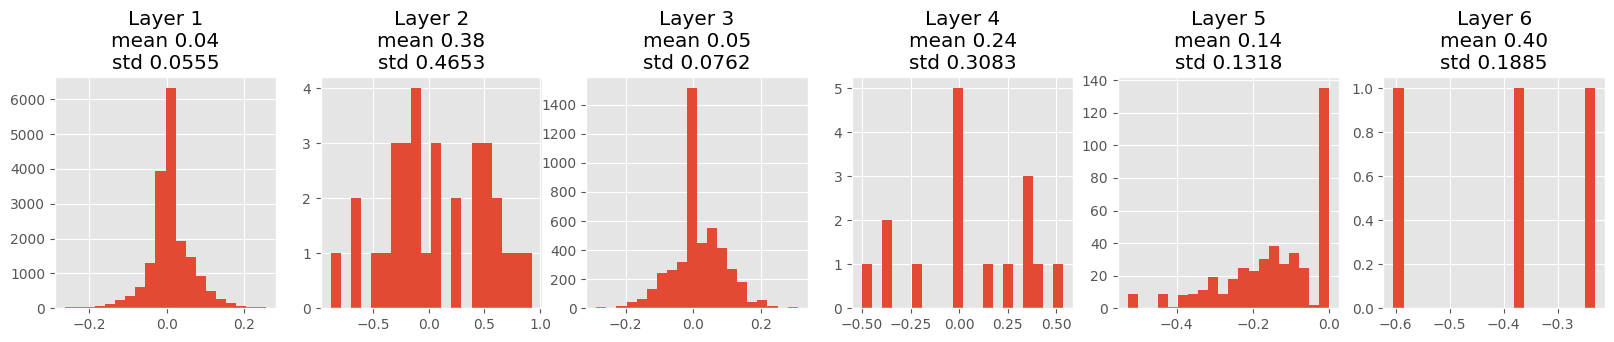

Activations:



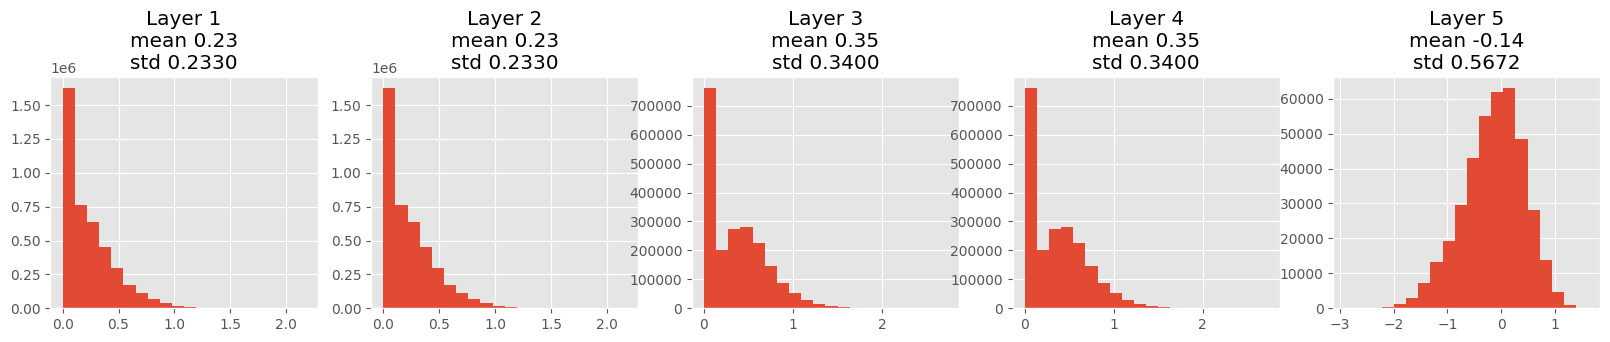

In [82]:
def plot_hist(hs,xrange=(-1,1),avg=None,sd=None):
  plt.figure(figsize=(20,3))
  for layer in range(len(hs)):
    plt.subplot(1,len(hs),layer+1)
    activations = hs[layer].detach().cpu().numpy().flatten()
    plt.hist(activations, bins=20, range=xrange)

    title = 'Layer ' + str(layer+1)
    if avg:
      title += '\n' + "mean {0:.2f}".format(avg[layer])
    if sd:
      title += '\n' + "std {0:.4f}".format(sd[layer])

    plt.title(title)

print('Gradients:\n')
plot_hist(gradients,xrange=None,avg=gradient_mean,sd=gradient_std)
plt.show()

print('Activations:\n')
plot_hist(activations,xrange=None,avg=activation_mean,sd=activation_std)
plt.show()
